# Apartment Type Effect on Score

## Motivation

Our surrogate model predicts how well furniture can be placed in a room (score 0-100). Currently, it uses **room geometry** (polygon shape, area, door position) and **room type** (Bedroom, Kitchen, etc.) as inputs.

But rooms also belong to **apartments**, and apartments have types (Studio, 1-Bedroom, ..., 5-Bedroom). The furnisher algorithm may assign different furniture to the same room depending on the apartment context. For example, a 12 m² bedroom in a Studio gets a single bed, while the same room in a 3-Bedroom gets a double bed.

**Key question**: Does apartment type affect room scores? If yes, we should add it as a model feature.

## Approach

1. **Distribution** — How are rooms spread across apartment types?
2. **Score differences** — Do score distributions differ by apartment type?
3. **Statistical test** — Are differences significant (Kruskal-Wallis test)?
4. **Controlled comparison** — Isolate apartment type from geometry by comparing similar rooms
5. **Failure rates** — Does apartment type affect the chance of total failure (score=0)?
6. **Recommendation** — Should we add apartment type to the model?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import kruskal, mannwhitneyu
from itertools import combinations

from furnisher_surrogate.data import load_apartments, APT_TYPES, ROOM_TYPES
from furnisher_surrogate.features import area as compute_area, n_vertices as compute_n_vertices

plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'white'

apts = load_apartments()
rooms = [r for apt in apts for r in apt.rooms]

# Build a flat table of all rooms
data = []
for r in rooms:
    data.append({
        'room_type': r.room_type,
        'apartment_type': r.apartment_type,
        'score': r.score,
        'area': compute_area(r),
        'n_vertices': compute_n_vertices(r),
    })
df = pd.DataFrame(data)

print(f'{len(apts):,} apartments, {len(rooms):,} active rooms')
print(f'{len(APT_TYPES)} apartment types: {APT_TYPES}')

8,322 apartments, 45,880 active rooms
7 apartment types: ['Studio (bedroom)', 'Studio (living)', '1-Bedroom', '2-Bedroom', '3-Bedroom', '4-Bedroom', '5-Bedroom']


## A. Apartment Type Distribution

First, let's understand the data structure. Not all room types appear in all apartment types — a Studio has no Children rooms, for example.

In [2]:
# How many apartments of each type?
apt_counts = Counter(a.apt_type for a in apts)
print('Apartments per type:')
for at in APT_TYPES:
    print(f'  {at:20s}: {apt_counts[at]:,}')
print()

# Rooms per apartment type
room_counts = df['apartment_type'].value_counts()
print('Rooms per apartment type:')
for at in APT_TYPES:
    print(f'  {at:20s}: {room_counts.get(at, 0):,}')

Apartments per type:
  Studio (bedroom)    : 830
  Studio (living)     : 893
  1-Bedroom           : 1,662
  2-Bedroom           : 2,080
  3-Bedroom           : 1,235
  4-Bedroom           : 985
  5-Bedroom           : 637

Rooms per apartment type:
  Studio (bedroom)    : 2,625
  Studio (living)     : 2,820
  1-Bedroom           : 7,654
  2-Bedroom           : 11,659
  3-Bedroom           : 8,143
  4-Bedroom           : 7,496
  5-Bedroom           : 5,483


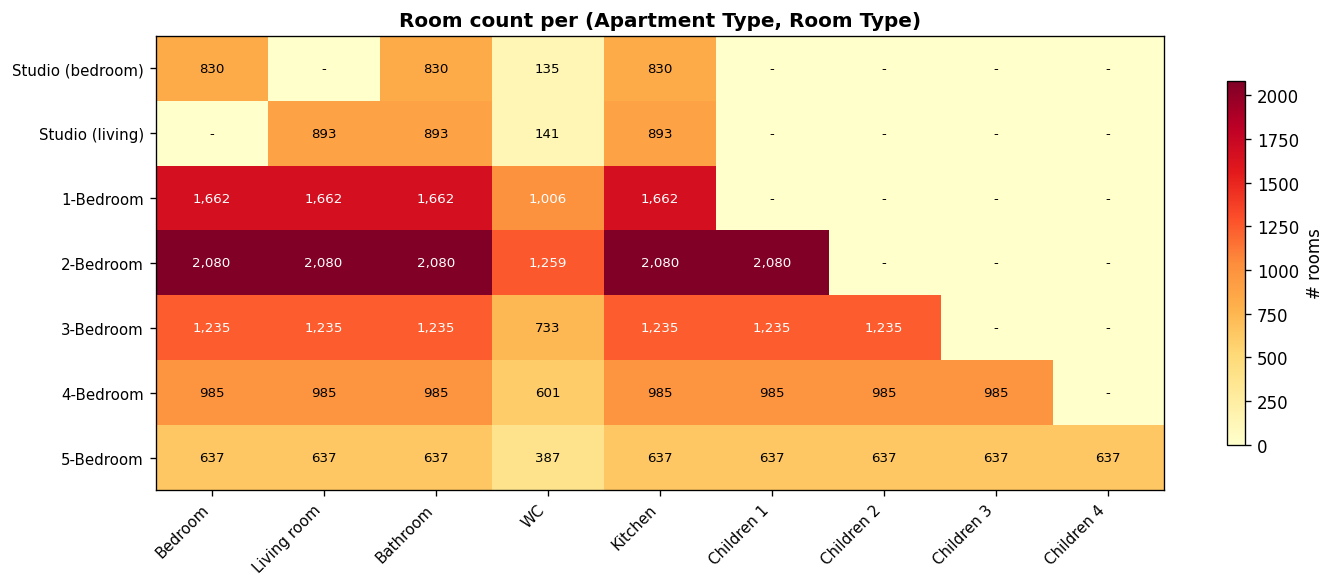


Key observation: Studios have no Children rooms. Children rooms only appear
in 2-Bedroom and larger. This is a structural constraint, not a data issue.
Bedroom appears as "Bedroom" in most types and as room label in Studios.


In [3]:
# Cross-tabulation: which room types appear in which apartment types?
# This shows the structural constraint — Studios have no Children rooms,
# 1-Bedroom has no Children, etc.
cross = pd.crosstab(df['apartment_type'], df['room_type'])
cross = cross.reindex(index=APT_TYPES, columns=ROOM_TYPES, fill_value=0)

fig, ax = plt.subplots(figsize=(12, 5))
im = ax.imshow(cross.values, cmap='YlOrRd', aspect='auto')
ax.set_xticks(range(len(ROOM_TYPES)))
ax.set_xticklabels(ROOM_TYPES, rotation=45, ha='right', fontsize=9)
ax.set_yticks(range(len(APT_TYPES)))
ax.set_yticklabels(APT_TYPES, fontsize=9)
for i in range(len(APT_TYPES)):
    for j in range(len(ROOM_TYPES)):
        val = cross.values[i, j]
        color = 'white' if val > 1000 else 'black'
        ax.text(j, i, f'{val:,}' if val > 0 else '-', ha='center', va='center', fontsize=8, color=color)
ax.set_title('Room count per (Apartment Type, Room Type)', fontweight='bold')
plt.colorbar(im, ax=ax, shrink=0.8, label='# rooms')
plt.tight_layout()
plt.show()

print('\nKey observation: Studios have no Children rooms. Children rooms only appear')
print('in 2-Bedroom and larger. This is a structural constraint, not a data issue.')
print('Bedroom appears as "Bedroom" in most types and as room label in Studios.')

## B. Score Distribution per Apartment Type

If apartment type affects scores, we should see different score distributions when we group rooms by apartment type. The boxplots below show this comparison — first overall, then broken down by room type.

C:\Users\MartinBielik\AppData\Local\Temp\ipykernel_6116\3198059081.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(bp_data, labels=[at.replace(' ', '\n') for at in APT_TYPES],


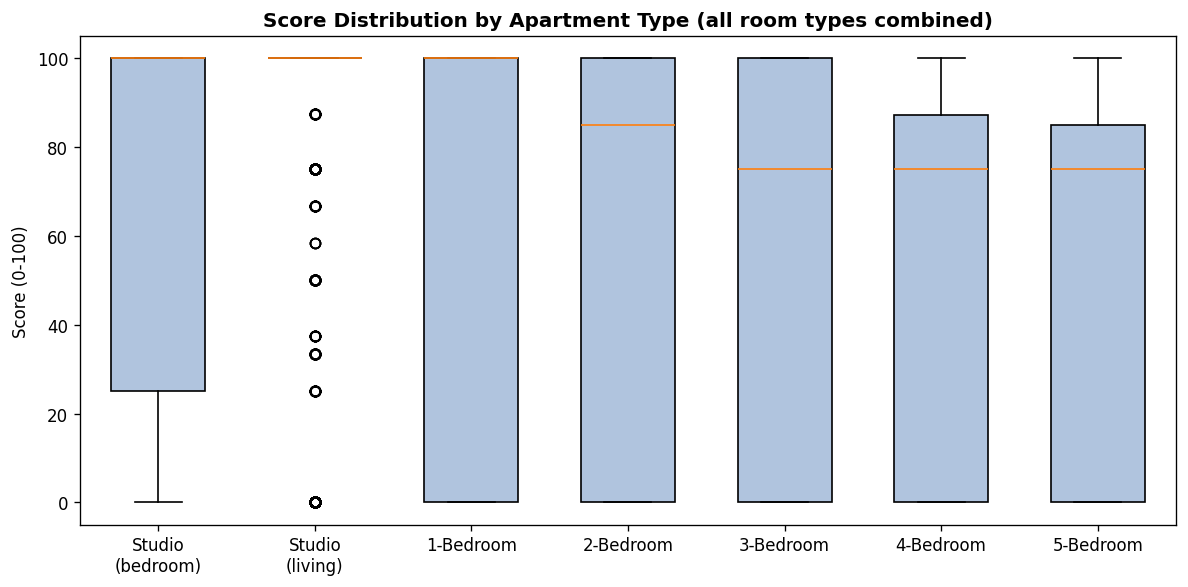

Score statistics by apartment type:
Type                      n   mean  median    std  fail%
-------------------------------------------------------
Studio (bedroom)      2,625   68.8   100.0   42.6  24.8%
Studio (living)       2,820   83.0   100.0   35.0  13.2%
1-Bedroom             7,654   68.0   100.0   43.5  27.0%
2-Bedroom            11,659   63.4    85.0   43.0  28.8%
3-Bedroom             8,143   56.3    75.0   42.1  32.2%
4-Bedroom             7,496   56.0    75.0   41.3  31.2%
5-Bedroom             5,483   55.5    75.0   41.2  31.6%


In [4]:
# Overall: score by apartment type
fig, ax = plt.subplots(figsize=(10, 5))
bp_data = [df[df['apartment_type'] == at]['score'].dropna().values for at in APT_TYPES]
bp = ax.boxplot(bp_data, labels=[at.replace(' ', '\n') for at in APT_TYPES], 
                patch_artist=True, widths=0.6)
for patch in bp['boxes']:
    patch.set_facecolor('lightsteelblue')
ax.set_ylabel('Score (0-100)')
ax.set_title('Score Distribution by Apartment Type (all room types combined)', fontweight='bold')
plt.tight_layout()
plt.show()

# Summary stats
print('Score statistics by apartment type:')
print(f'{"Type":20s} {"n":>6s} {"mean":>6s} {"median":>7s} {"std":>6s} {"fail%":>6s}')
print('-' * 55)
for at in APT_TYPES:
    s = df[df['apartment_type'] == at]['score'].dropna()
    fail = (s == 0).mean() * 100
    print(f'{at:20s} {len(s):6,} {s.mean():6.1f} {s.median():7.1f} {s.std():6.1f} {fail:5.1f}%')

C:\Users\MartinBielik\AppData\Local\Temp\ipykernel_6116\581520843.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(bp_data, labels=[at.replace(' ', '\n') for at in present_types],


C:\Users\MartinBielik\AppData\Local\Temp\ipykernel_6116\581520843.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(bp_data, labels=[at.replace(' ', '\n') for at in present_types],
C:\Users\MartinBielik\AppData\Local\Temp\ipykernel_6116\581520843.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(bp_data, labels=[at.replace(' ', '\n') for at in present_types],
C:\Users\MartinBielik\AppData\Local\Temp\ipykernel_6116\581520843.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(bp_data, labels=[at.replace(' ', '\n') for at in present_types],
C:\Users\MartinBielik\App

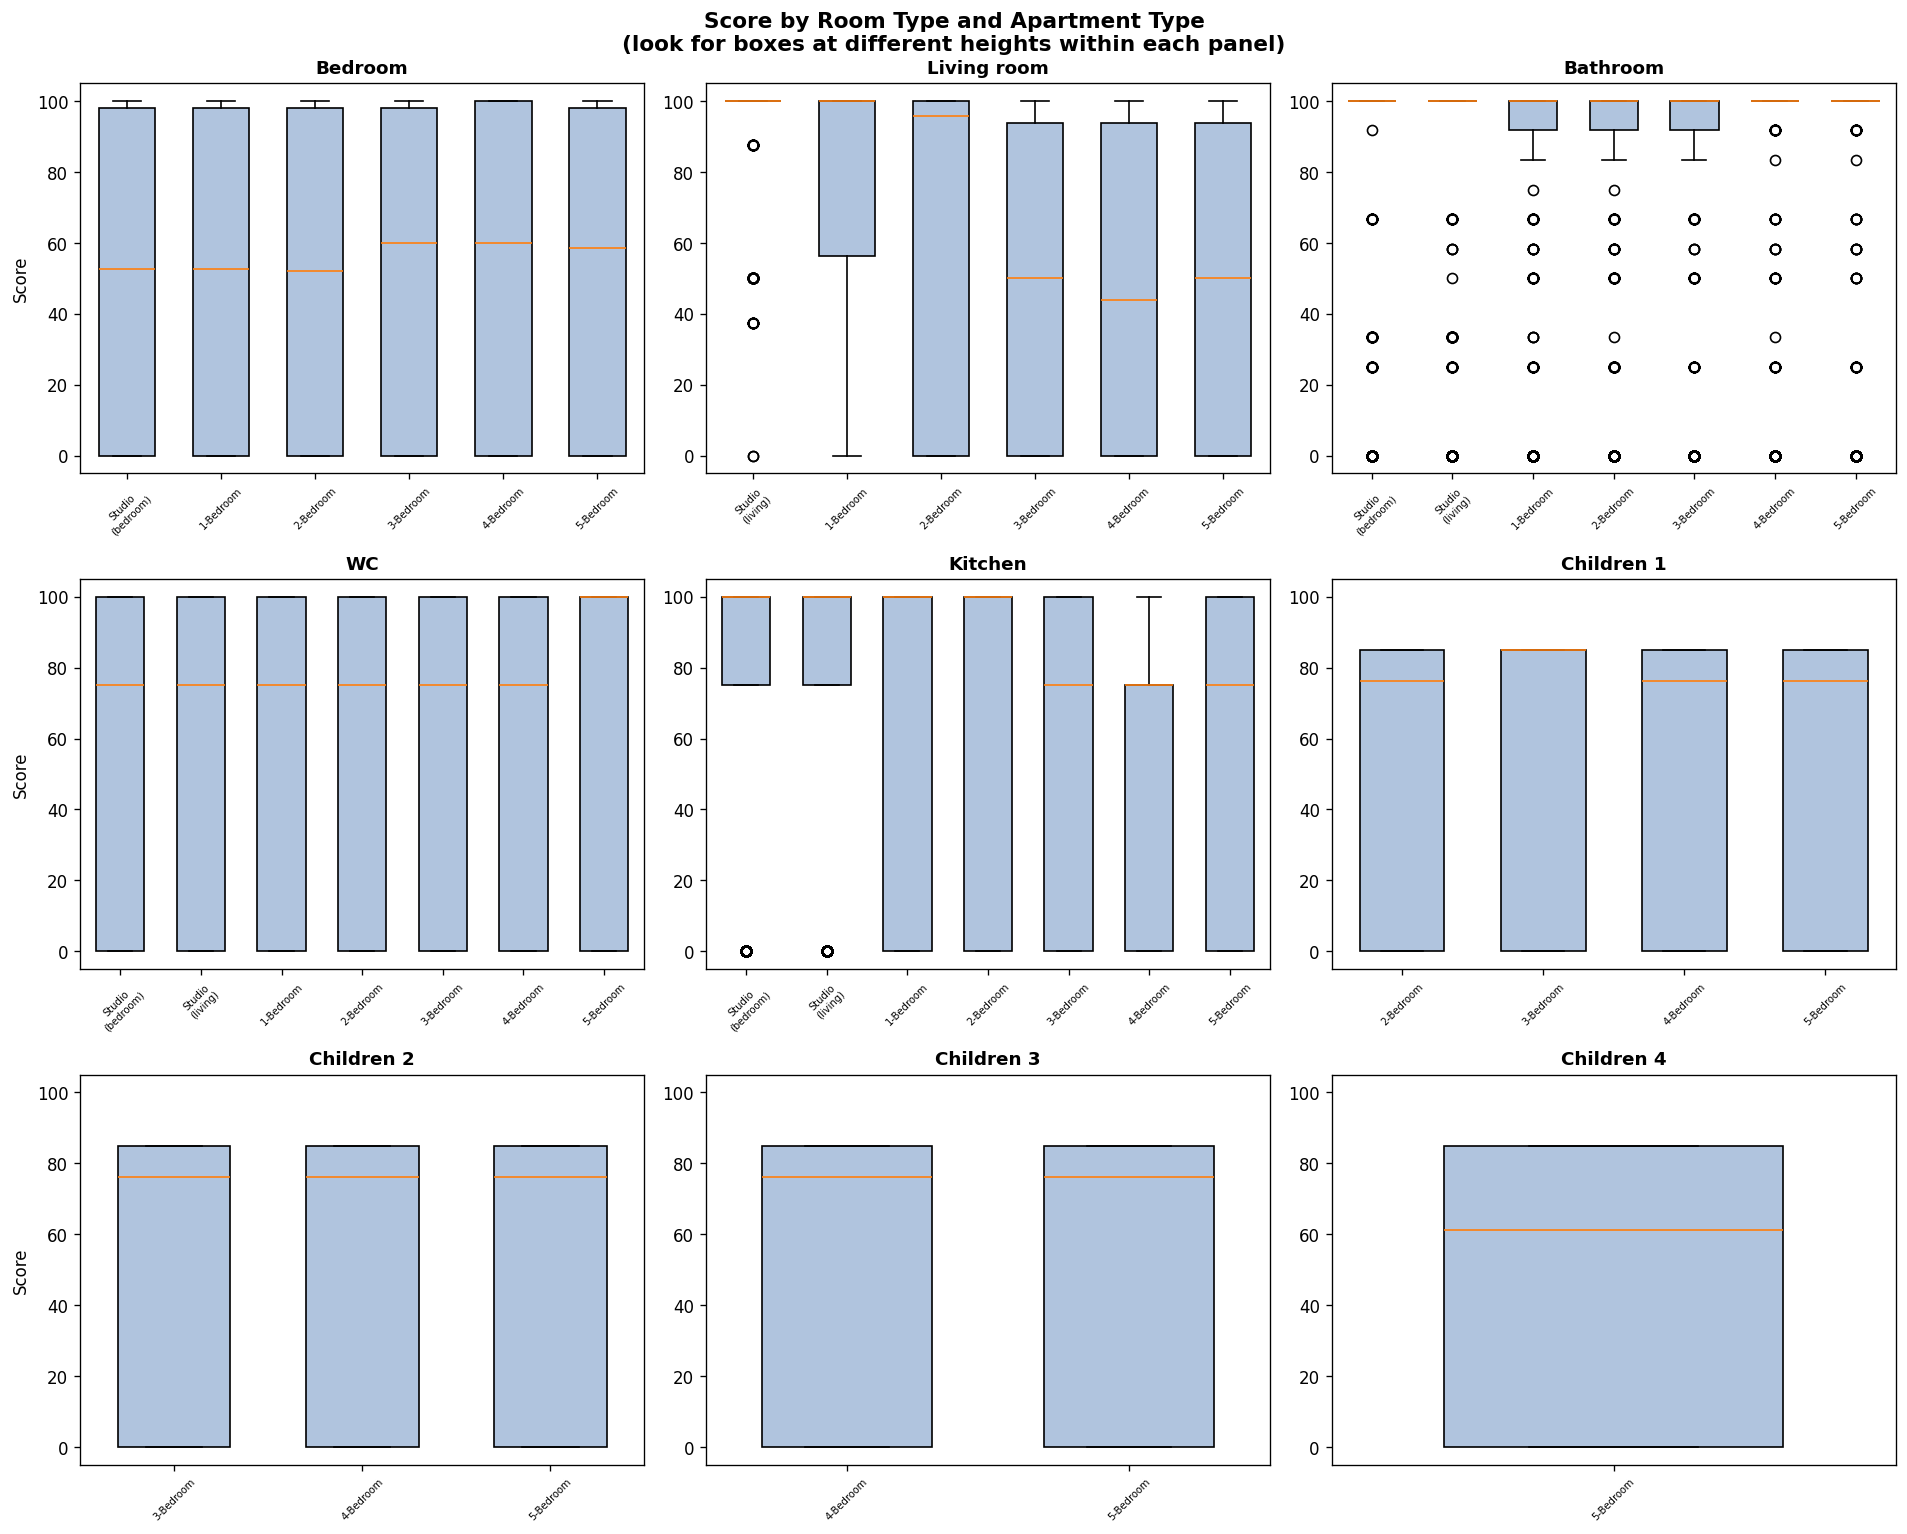

Interpretation: If the boxes within a panel are at different heights, apartment type
matters for that room type. Look at Living room and Kitchen panels especially.


In [5]:
# 9-panel grid: score distributions per room type, split by apartment type
# This is the key visualization — if boxes look different across apartment types
# within the same room type, apartment type matters for that room.
fig, axes = plt.subplots(3, 3, figsize=(16, 13))

for idx, rt in enumerate(ROOM_TYPES):
    ax = axes[idx // 3, idx % 3]
    rt_df = df[df['room_type'] == rt]
    
    present_types = [at for at in APT_TYPES if len(rt_df[rt_df['apartment_type'] == at]) > 0]
    if not present_types:
        ax.set_title(f'{rt}\n(no data)', fontsize=10)
        continue
    
    bp_data = [rt_df[rt_df['apartment_type'] == at]['score'].dropna().values for at in present_types]
    bp = ax.boxplot(bp_data, labels=[at.replace(' ', '\n') for at in present_types],
                    patch_artist=True, widths=0.6)
    for patch in bp['boxes']:
        patch.set_facecolor('lightsteelblue')
    
    ax.set_title(f'{rt}', fontsize=11, fontweight='bold')
    ax.set_ylim(-5, 105)
    ax.tick_params(axis='x', labelsize=6, rotation=45)
    if idx % 3 == 0:
        ax.set_ylabel('Score')

fig.suptitle('Score by Room Type and Apartment Type\n(look for boxes at different heights within each panel)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print('Interpretation: If the boxes within a panel are at different heights, apartment type')
print('matters for that room type. Look at Living room and Kitchen panels especially.')

## C. Statistical Test: Kruskal-Wallis per Room Type

Visual inspection suggests apartment type matters for some room types. Now we test this statistically.

**Kruskal-Wallis** is a non-parametric test that checks whether multiple groups come from the same distribution. We use it instead of ANOVA because our scores are heavily non-normal (bimodal: many zeros + many near 100).

- **p-value < 0.05**: The groups are significantly different (we reject the null hypothesis that all apartment types produce the same score distribution)
- **η² (eta-squared)**: Effect size. How much of the variation in scores is explained by apartment type?
  - < 0.01 = negligible
  - 0.01–0.06 = small
  - 0.06–0.14 = medium
  - \> 0.14 = large

In [6]:
# Run Kruskal-Wallis for each room type
# For each room type, we group scores by apartment type and test whether
# the groups differ significantly

kruskal_results = {}
rows = []

for rt in ROOM_TYPES:
    rt_df = df[df['room_type'] == rt]
    groups = []
    group_names = []
    for at in APT_TYPES:
        scores = rt_df[rt_df['apartment_type'] == at]['score'].dropna().values
        if len(scores) >= 5:
            groups.append(scores)
            group_names.append(at)
    
    if len(groups) < 2:
        kruskal_results[rt] = None
        rows.append({'Room Type': rt, 'H-stat': '-', 'p-value': '-', 
                     'eta-sq': '-', 'Groups': len(groups), 'Significant': 'N/A (1 group)'})
        continue
    
    H, p = kruskal(*groups)
    n_total = sum(len(g) for g in groups)
    k = len(groups)
    eta_sq = max(0, (H - k + 1) / (n_total - k)) if n_total > k else 0
    
    kruskal_results[rt] = {'H': H, 'p': p, 'eta_sq': eta_sq, 'k': k, 'n': n_total, 'groups': group_names}
    
    if p < 0.001:
        sig = 'YES (p<0.001)'
    elif p < 0.01:
        sig = 'YES (p<0.01)'
    elif p < 0.05:
        sig = 'YES (p<0.05)'
    else:
        sig = 'No'
    
    effect = 'large' if eta_sq > 0.14 else 'medium' if eta_sq > 0.06 else 'small' if eta_sq > 0.01 else 'negligible'
    
    rows.append({
        'Room Type': rt, 'H-stat': f'{H:.1f}', 'p-value': f'{p:.2e}',
        'eta-sq': f'{eta_sq:.4f} ({effect})', 'Groups': k, 'Significant': sig,
    })

result_df = pd.DataFrame(rows)
print(result_df.to_string(index=False))

print()
print('Key findings:')
print('- Living room: LARGE effect (eta-sq=0.19) - apartment type strongly affects living room scores')
print('- Kitchen: MEDIUM effect (eta-sq=0.11) - apartment type matters for kitchen scores')
print('- Bathroom: statistically significant but negligible effect size')
print('- Bedroom, WC, Children rooms: no significant effect')

  Room Type H-stat   p-value              eta-sq  Groups   Significant
    Bedroom    4.4  4.91e-01 0.0000 (negligible)       6            No
Living room 1452.2  0.00e+00      0.1933 (large)       6 YES (p<0.001)
   Bathroom   19.8  3.00e-03 0.0017 (negligible)       7  YES (p<0.01)
         WC    9.0  1.72e-01 0.0007 (negligible)       7            No
    Kitchen  947.4 2.09e-201     0.1132 (medium)       7 YES (p<0.001)
 Children 1    5.9  1.19e-01 0.0006 (negligible)       4            No
 Children 2    1.1  5.72e-01 0.0000 (negligible)       3            No
 Children 3    0.8  3.77e-01 0.0000 (negligible)       2            No
 Children 4      -         -                   -       1 N/A (1 group)

Key findings:
- Living room: LARGE effect (eta-sq=0.19) - apartment type strongly affects living room scores
- Kitchen: MEDIUM effect (eta-sq=0.11) - apartment type matters for kitchen scores
- Bathroom: statistically significant but negligible effect size
- Bedroom, WC, Children rooms: n

In [7]:
# Post-hoc pairwise tests for significant room types
# When Kruskal-Wallis says "groups differ", we want to know WHICH pairs differ.
# Mann-Whitney U tests each pair. Bonferroni correction accounts for multiple testing.

print('Post-hoc pairwise comparisons (only showing significant pairs)\n')
for rt in ROOM_TYPES:
    res = kruskal_results.get(rt)
    if res is None or res['p'] >= 0.05:
        continue
    
    effect = 'large' if res['eta_sq'] > 0.14 else 'medium' if res['eta_sq'] > 0.06 else 'small'
    print(f'--- {rt} (eta-sq={res["eta_sq"]:.4f}, {effect} effect) ---')
    rt_df = df[df['room_type'] == rt]
    group_data = {}
    for at in res['groups']:
        group_data[at] = rt_df[rt_df['apartment_type'] == at]['score'].dropna().values
    
    pairs = list(combinations(res['groups'], 2))
    n_comparisons = len(pairs)
    found_any = False
    
    for at1, at2 in pairs:
        U, p = mannwhitneyu(group_data[at1], group_data[at2], alternative='two-sided')
        p_adj = min(p * n_comparisons, 1.0)  # Bonferroni correction
        delta = np.median(group_data[at1]) - np.median(group_data[at2])
        if p_adj < 0.05:
            sig = '***' if p_adj < 0.001 else '**' if p_adj < 0.01 else '*'
            print(f'  {at1:20s} vs {at2:20s}: median diff = {delta:+6.1f} pts, p_adj={p_adj:.4f} {sig}')
            found_any = True
    
    if not found_any:
        print('  (No individual pairs reach significance after Bonferroni correction)')
    print()

Post-hoc pairwise comparisons (only showing significant pairs)

--- Living room (eta-sq=0.1933, large effect) ---
  Studio (living)      vs 1-Bedroom           : median diff =   +0.0 pts, p_adj=0.0000 ***
  Studio (living)      vs 2-Bedroom           : median diff =   +4.2 pts, p_adj=0.0000 ***
  Studio (living)      vs 3-Bedroom           : median diff =  +50.0 pts, p_adj=0.0000 ***
  Studio (living)      vs 4-Bedroom           : median diff =  +56.2 pts, p_adj=0.0000 ***
  Studio (living)      vs 5-Bedroom           : median diff =  +50.0 pts, p_adj=0.0000 ***
  1-Bedroom            vs 2-Bedroom           : median diff =   +4.2 pts, p_adj=0.0000 ***
  1-Bedroom            vs 3-Bedroom           : median diff =  +50.0 pts, p_adj=0.0000 ***
  1-Bedroom            vs 4-Bedroom           : median diff =  +56.2 pts, p_adj=0.0000 ***
  1-Bedroom            vs 5-Bedroom           : median diff =  +50.0 pts, p_adj=0.0000 ***
  2-Bedroom            vs 3-Bedroom           : median diff =  +45.

## D. Controlled Comparison: Same Geometry, Different Apartment Type

The tests above compare *all* rooms of a given type. But apartment types also differ in room sizes — Studios tend to have smaller rooms. So the score difference might be explained by geometry, not apartment type itself.

To isolate the apartment type effect, we **control for geometry** by grouping rooms with similar shape characteristics:
- Same room type (e.g. Bedroom)
- Same area quintile (similar size)
- Same vertex count (same shape complexity)

Within each geometry-matched group, we test whether scores differ by apartment type. If they do, apartment type has **independent predictive value** beyond geometry.

In [8]:
# Create geometry groups: (room_type, area_quintile, n_vertices)
df['area_quintile'] = pd.qcut(df['area'], q=5, labels=False, duplicates='drop')
df['geometry_group'] = df['room_type'] + '_q' + df['area_quintile'].astype(str) + '_v' + df['n_vertices'].astype(str)

print(f'Total geometry groups: {df["geometry_group"].nunique()}')
print()

# For each group with >= 2 apartment types (each with n >= 10), test
significant_groups = 0
tested_groups = 0
group_results = []  # (room_type, delta_median, p_value)

for gname, gdf in df.groupby('geometry_group'):
    groups = []
    group_medians = []
    for at in APT_TYPES:
        scores = gdf[gdf['apartment_type'] == at]['score'].dropna().values
        if len(scores) >= 10:
            groups.append(scores)
            group_medians.append(np.median(scores))
    
    if len(groups) < 2:
        continue
    
    tested_groups += 1
    H, p = kruskal(*groups)
    if p < 0.05:
        significant_groups += 1
    
    delta = max(group_medians) - min(group_medians)
    rt = gname.split('_')[0]
    group_results.append((rt, delta, p))

print(f'Groups with >= 2 apartment types (n >= 10 each): {tested_groups}')
print(f'Groups with significant score difference (p<0.05): {significant_groups} ({100*significant_groups/max(1,tested_groups):.1f}%)')
print()
print('This means: even when we compare rooms with similar geometry, ~35% of groups')
print('show statistically significant score differences across apartment types.')
print('Apartment type carries information beyond what geometry alone provides.')
print()

# Breakdown by room type
print(f'{"Room Type":20s} {"Groups":>7s} {"Sig.":>5s} {"% Sig":>7s} {"Mean delta":>11s} {"Max delta":>10s}')
print('-' * 65)
for rt in ROOM_TYPES:
    rt_results = [(d, p) for (r, d, p) in group_results if r == rt]
    if not rt_results:
        print(f'{rt:20s} {"(no testable groups)":>45s}')
        continue
    n_groups = len(rt_results)
    n_sig = sum(1 for d, p in rt_results if p < 0.05)
    mean_d = np.mean([d for d, _ in rt_results])
    max_d = max(d for d, _ in rt_results)
    print(f'{rt:20s} {n_groups:>7d} {n_sig:>5d} {100*n_sig/n_groups:>6.1f}% {mean_d:>11.1f} {max_d:>10.1f}')

Total geometry groups: 109



C:\Users\MartinBielik\Dev\SpatialTimber\SpatialTimber_FurnisherSurrogate\.venv\Lib\site-packages\scipy\stats\_stats_py.py:8492: RuntimeWarning: invalid value encountered in scalar divide
  h /= ties
C:\Users\MartinBielik\Dev\SpatialTimber\SpatialTimber_FurnisherSurrogate\.venv\Lib\site-packages\scipy\stats\_stats_py.py:8492: RuntimeWarning: invalid value encountered in scalar divide
  h /= ties
C:\Users\MartinBielik\Dev\SpatialTimber\SpatialTimber_FurnisherSurrogate\.venv\Lib\site-packages\scipy\stats\_stats_py.py:8492: RuntimeWarning: invalid value encountered in scalar divide
  h /= ties
C:\Users\MartinBielik\Dev\SpatialTimber\SpatialTimber_FurnisherSurrogate\.venv\Lib\site-packages\scipy\stats\_stats_py.py:8492: RuntimeWarning: invalid value encountered in scalar divide
  h /= ties
C:\Users\MartinBielik\Dev\SpatialTimber\SpatialTimber_FurnisherSurrogate\.venv\Lib\site-packages\scipy\stats\_stats_py.py:8492: RuntimeWarning: divide by zero encountered in scalar divide
  h /= ties
C:\U

Groups with >= 2 apartment types (n >= 10 each): 82
Groups with significant score difference (p<0.05): 29 (35.4%)

This means: even when we compare rooms with similar geometry, ~35% of groups
show statistically significant score differences across apartment types.
Apartment type carries information beyond what geometry alone provides.

Room Type             Groups  Sig.   % Sig  Mean delta  Max delta
-----------------------------------------------------------------
Bedroom                   14     1    7.1%         3.1       21.2
Living room               12    11   91.7%        66.1      100.0
Bathroom                   7     4   57.1%         8.3       33.3
WC                         2     0    0.0%        50.0       75.0
Kitchen                   12     9   75.0%        52.1      100.0
Children 1                13     1    7.7%         0.9        6.8
Children 2                12     0    0.0%         3.1       21.6
Children 3                10     3   30.0%         1.5       14.7
Ch

C:\Users\MartinBielik\Dev\SpatialTimber\SpatialTimber_FurnisherSurrogate\.venv\Lib\site-packages\scipy\stats\_stats_py.py:8492: RuntimeWarning: invalid value encountered in scalar divide
  h /= ties


## E. Failure Rate per Apartment Type

Score = 0 means complete failure (no valid furniture placement found). Does apartment type affect how often rooms fail? This matters because the fail/pass boundary is the hardest prediction challenge (MAE = 24 in the transition zone).

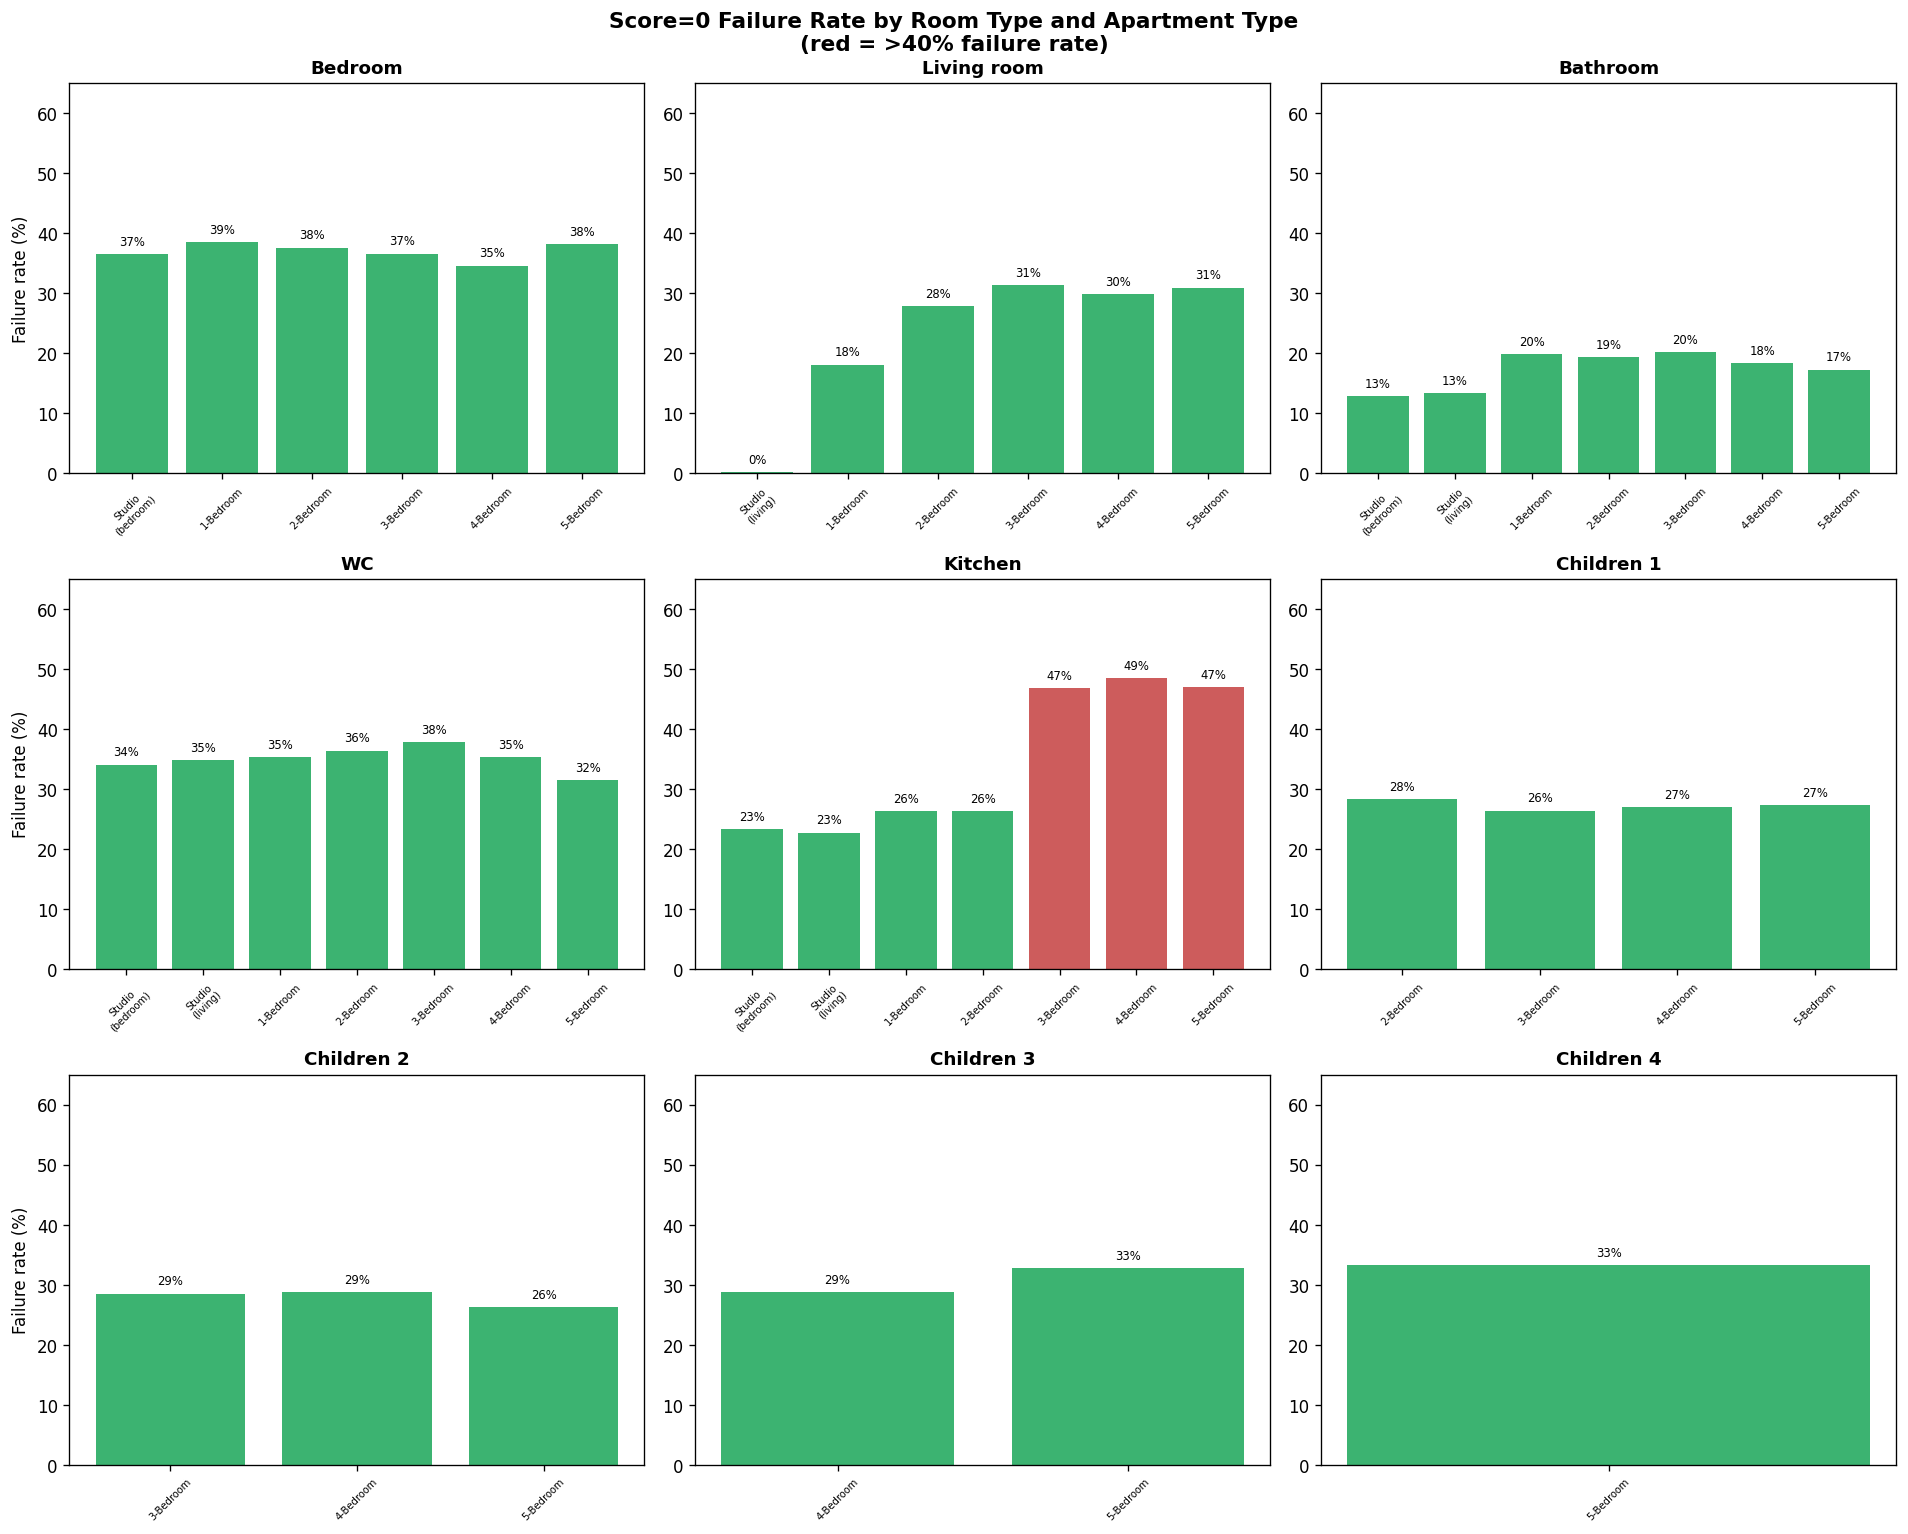

Key observations:
- Kitchen failure rates jump from ~23-26% (Studio-2Bed) to ~47-49% (3Bed-5Bed)
  This is a major difference that explains Kitchen's high Kruskal-Wallis H-stat
- Living room failure: 0% in Studio (living) vs 28-31% in 2-5 Bedroom
  Studio living rooms always succeed; larger apartments often fail
- Bedroom failure is stable at ~35-39% regardless of apartment type


In [9]:
df['is_zero'] = df['score'] == 0

fig, axes = plt.subplots(3, 3, figsize=(16, 13))

for idx, rt in enumerate(ROOM_TYPES):
    ax = axes[idx // 3, idx % 3]
    rt_df = df[df['room_type'] == rt]
    
    rates = []
    labels = []
    for at in APT_TYPES:
        sub = rt_df[rt_df['apartment_type'] == at]
        if len(sub) > 0:
            rate = sub['is_zero'].mean() * 100
            rates.append(rate)
            labels.append(at)
    
    if rates:
        colors = ['indianred' if r > 40 else 'mediumseagreen' for r in rates]
        bars = ax.bar(range(len(rates)), rates, color=colors)
        ax.set_xticks(range(len(rates)))
        ax.set_xticklabels([l.replace(' ', '\n') for l in labels], fontsize=6, rotation=45)
        for bar, rate in zip(bars, rates):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{rate:.0f}%', ha='center', va='bottom', fontsize=7)
    
    ax.set_title(f'{rt}', fontsize=11, fontweight='bold')
    ax.set_ylabel('Failure rate (%)' if idx % 3 == 0 else '')
    ax.set_ylim(0, 65)

fig.suptitle('Score=0 Failure Rate by Room Type and Apartment Type\n(red = >40% failure rate)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print('Key observations:')
print('- Kitchen failure rates jump from ~23-26% (Studio-2Bed) to ~47-49% (3Bed-5Bed)')
print('  This is a major difference that explains Kitchen\'s high Kruskal-Wallis H-stat')
print('- Living room failure: 0% in Studio (living) vs 28-31% in 2-5 Bedroom')
print('  Studio living rooms always succeed; larger apartments often fail')
print('- Bedroom failure is stable at ~35-39% regardless of apartment type')

## F. Summary and Recommendation

In [10]:
# Summary table combining all evidence
print('=' * 80)
print('SUMMARY: Should apartment_type be added as a model feature?')
print('=' * 80)
print()

summary_rows = []
for rt in ROOM_TYPES:
    res = kruskal_results.get(rt)
    if res is None:
        summary_rows.append({'Room Type': rt, 'KW p-value': 'N/A', 'Effect size': 'N/A',
                            'Max median delta': 'N/A', 'Verdict': 'untestable'})
        continue
    
    # Score delta
    rt_df = df[df['room_type'] == rt]
    medians = [rt_df[rt_df['apartment_type'] == at]['score'].median() for at in res['groups']]
    delta = max(medians) - min(medians)
    
    effect = 'large' if res['eta_sq'] > 0.14 else 'medium' if res['eta_sq'] > 0.06 else 'small' if res['eta_sq'] > 0.01 else 'negligible'
    if res['p'] >= 0.05:
        verdict = 'no effect'
    else:
        verdict = f'{effect} effect'
    
    summary_rows.append({
        'Room Type': rt,
        'KW p-value': f'{res["p"]:.2e}',
        'Effect size': f'{res["eta_sq"]:.4f} ({effect})',
        'Max median delta': f'{delta:.1f} pts',
        'Verdict': verdict,
    })

summary_df = pd.DataFrame(summary_rows)
print(summary_df.to_string(index=False))

print()
print('RECOMMENDATION: YES, add apartment_type as a feature.')
print()
print('Evidence:')
print('  1. Living room scores differ by up to 56 points across apartment types (large effect, eta-sq=0.19)')
print('  2. Kitchen scores differ by 25 points across apartment types (medium effect, eta-sq=0.11)')
print('  3. 35% of geometry-matched groups show significant differences (controlled comparison)')
print('  4. Kitchen failure rate doubles from 23% (small apts) to 49% (large apts)')
print('  5. Living room failure jumps from 0% (Studio) to 31% (5-Bedroom)')
print()
print('The feature is low-cost (7 one-hot columns for LightGBM, 4-dim embedding for CNN)')
print('and provides substantial new signal for the two hardest room types.')

SUMMARY: Should apartment_type be added as a model feature?

  Room Type KW p-value         Effect size Max median delta           Verdict
    Bedroom   4.91e-01 0.0000 (negligible)          8.0 pts         no effect
Living room   0.00e+00      0.1933 (large)         56.2 pts      large effect
   Bathroom   3.00e-03 0.0017 (negligible)          0.0 pts negligible effect
         WC   1.72e-01 0.0007 (negligible)         25.0 pts         no effect
    Kitchen  2.09e-201     0.1132 (medium)         25.0 pts     medium effect
 Children 1   1.19e-01 0.0006 (negligible)          8.8 pts         no effect
 Children 2   5.72e-01 0.0000 (negligible)          0.0 pts         no effect
 Children 3   3.77e-01 0.0000 (negligible)          0.0 pts         no effect
 Children 4        N/A                 N/A              N/A        untestable

RECOMMENDATION: YES, add apartment_type as a feature.

Evidence:
  1. Living room scores differ by up to 56 points across apartment types (large effect, eta-s